In [1]:
import pandas as pd
import numpy as np
import math
from copy import deepcopy


#############################
# Import and combine all data
#############################


#DATA_PATH = "/Users/mvonebers/HUBBS-Lab/data/"
DATA_PATH = "/home/maggie/HUBBS-Lab/data/"

e4_data = pd.read_excel(DATA_PATH + "E4_TEST.xlsx")
change_data = pd.read_excel(DATA_PATH + "normalized_change.xlsx")
audio_data = pd.read_excel(DATA_PATH + "audio_TEST.xlsx")
demo_data = pd.read_csv(DATA_PATH + "Demographics Information.csv")


# Break apart the ID column into "person" and "trial"
def clean_id(data):
    data.insert(0, "person", [0] * data.shape[0])
    data.insert(1, "trial", [0] * data.shape[0])

    for i, row in data.iterrows():
        data.at[i, "person"] = int(data.at[i, "id"][7:])
        data.at[i, "trial"] = int(data.at[i, "id"][5])
    
    data = data.drop(columns=['id'])
    data = data.rename(columns={"person": "id"})
    return data

    
e4_data = clean_id(e4_data)
audio_data = clean_id(audio_data)

# Normalize and print out indices for ease of reference
#for dframe, name in zip([e4_data, audio_data], ['e4_data', 'audio_data']):
#    for i, col in zip(range(len(dframe.columns.to_list())), dframe.columns.to_list()):
#        if not (col == 'id' or col == 'trial'):
#            dframe[col] = dframe[col]/dframe[col].max()
#        print(name + '[' + str(i) + ']: ' + str(col))

for col in audio_data.columns.to_list():
    if col != 'id' and col != 'trial':
        audio_data[col] = (audio_data[col] - audio_data[col].mean())/audio_data[col].std()
        #audio_data[col] = (audio_data[col] - audio_data[col].min())/(audio_data[col].max() - audio_data[col].min())
        
for col in e4_data.columns.to_list():
    if col != 'id' and col != 'trial':
        #e4_data[col] = (e4_data[col] - e4_data[col].mean())/e4_data[col].std()
        e4_data[col] = (e4_data[col] - e4_data[col].min())/(e4_data[col].max() - e4_data[col].min())
        
for col in demo_data.columns.to_list():
    if col != 'id' and col != 'trial':
        demo_data[col] = (demo_data[col] - demo_data[col].mean())/demo_data[col].std()
        #demo_data[col] = (demo_data[col] - demo_data[col].min())/(demo_data[col].max() - demo_data[col].min())

In [2]:
demo_data

,id,Age,Gender,Lang,college,presentation,ethnicity,presentation_3_months,highest_education
0,4,2.295170,-1.018350,1.790287,-0.962250,-0.343763,-1.129136,-1.274755,2.589614
1,5,0.854017,0.945611,1.790287,-0.962250,-1.187545,-1.129136,0.000000,1.000533
2,8,-0.587137,0.945611,-0.537086,-0.962250,0.500019,-0.305172,1.274755,-0.588549
3,16,2.295170,-1.018350,-0.537086,-0.096225,-0.343763,0.518792,-1.274755,1.000533
4,20,-0.587137,-1.018350,1.790287,0.769800,-1.187545,-0.305172,1.274755,-0.588549
5,21,-0.587137,-1.018350,-0.537086,-0.962250,-0.343763,-0.305172,-1.274755,-0.588549
6,23,-0.587137,-1.018350,-0.537086,-0.962250,-0.343763,-0.305172,-1.274755,-0.588549
7,27,-0.587137,-1.018350,-0.537086,-0.096225,-0.343763,-0.305172,-1.274755,1.000533
8,32,0.854017,0.945611,1.790287,-0.962250,-0.343763,-1.129136,0.000000,1.000533
9,35,-0.587137,0.945611,-0.537086,0.769800,1.343800,-1.129136,1.274755,-0.588549


In [3]:
audio_set = set(audio_data['id'].to_list())
e4_set = set(e4_data['id'].to_list())
change_set = set(change_data['id'].to_list())
demo_set = set(demo_data['id'].to_list())

e4_change_ids = audio_set.difference(change_set)
print(audio_set)
print(len(e4_set))
print(change_set)

#demo_data = demo_data['id'] != 27
#demo_data = demo_data['id'] != 43
#demo_data = demo_data['id'] != 49

#audio_data = audio_data['id'] != 66
#for i in e4_change_ids:
#    e4_data = e4_data['id'] != 

{4, 5, 8, 16, 20, 21, 23, 32, 35, 37, 38, 41, 42, 44, 46, 47, 50, 51, 53, 58, 61, 62, 65, 71, 73}
20
{4, 5, 8, 16, 20, 21, 23, 32, 35, 37, 38, 41, 42, 44, 46, 47, 50, 51, 53, 58, 61, 62, 65, 66, 71, 73}


In [4]:
###############################################################
# Get slopes from linear regression of the 8 trials for each ID
###############################################################

from sklearn.linear_model import LinearRegression

def get_slopes(data, start, end):
    iterations = int(data.shape[0]/8)
    y0 = data['trial'].to_numpy(copy=True)

    slopes = pd.DataFrame(np.zeros((iterations, data.shape[1])), columns=data.columns)
    missing_trials = pd.DataFrame(np.zeros((iterations, data.shape[1])), columns=data.columns)
    missing_trials = missing_trials.drop(["trial"], axis=1)
    slopes = slopes.drop(["trial"], axis=1)

    for col in range(2, data.shape[1]):
        x1 = data[data.columns[col]]
        y0 = list(range(start, end + 1))
        for row in range(iterations):
            missing = 0
            x0 = x1[ (row * 8) + start - 1 : (row * 8) + end ].to_numpy()
            x = np.array([])
            y = np.array([])
            
            slopes.iloc[row, 0] = data.iloc[row * 8, 0]

            for i in range(len(x0)):  # remove NaN from data
                if math.isnan(x0[i]) or math.isnan(y0[i]):
                    missing += 1
                elif x0[i] == 0: #and not data.columns[col] == '#pause':
                    missing += 1
                else:
                    x = np.append(x, x0[i])
                    y = np.append(y, y0[i])
                    
            missing_trials.iloc[row, col - 1] = missing
                    
            try:
                reg = LinearRegression().fit(y.reshape(-1,1),x)
                slopes.iloc[row, col - 1] = reg.coef_
            except:
                 slopes.iloc[row, col - 1] = 0
                    
    slopes.replace(0, np.NaN, inplace=True)
    missing_trials['id'] = slopes['id']
    
    return slopes, missing_trials

In [5]:
e4_slopes, e4_missing = get_slopes(e4_data, 1, 8)
audio_slopes, audio_missing = get_slopes(audio_data, 1, 8)
audio_slopes

,id,pcm_RMSenergy_sma_amean,pcm_fftMag_mfcc_sma[1]_amean,pcm_fftMag_mfcc_sma[2]_amean,pcm_fftMag_mfcc_sma[3]_amean,pcm_fftMag_mfcc_sma[4]_amean,pcm_fftMag_mfcc_sma[5]_amean,pcm_fftMag_mfcc_sma[6]_amean,pcm_fftMag_mfcc_sma[7]_amean,pcm_fftMag_mfcc_sma[8]_amean,...,voiceProb_sma_amean,F0_sma_amean,#pause,pause_frequency,pause_interval,mean,percent,jitterLocal_sma_amean,jitterDDP_sma_amean,shimmerLocal_sma_amean
0,4.0,-0.113950,-0.589168,0.503913,-0.161180,-0.166268,-0.096814,0.368405,-0.275989,0.182677,...,-0.142138,-0.086125,-2.149265e-02,-0.016788,0.174736,0.220541,0.009604,-0.353464,-0.340881,-0.403792
1,5.0,-0.607629,0.011030,0.014272,0.092828,0.442773,-0.417940,0.508767,-0.076610,-0.006522,...,-0.075389,-0.033942,7.119441e-02,0.102415,-0.064911,-0.005438,0.068160,-0.111454,-0.092667,-0.227236
2,8.0,0.233124,-0.270348,-0.080805,0.173545,-0.310999,-0.113108,0.162641,-0.233570,-0.007345,...,0.014827,0.017197,1.800010e-01,0.250480,0.031759,0.025668,0.293234,-0.436669,-0.375350,-0.280924
3,16.0,0.003521,-0.143791,0.007360,0.069564,-0.020245,-0.055563,0.017170,-0.126189,0.003652,...,0.001037,0.017125,-2.861209e-01,-0.327501,-0.148226,-0.164833,-0.493769,0.065743,0.077192,0.096370
4,20.0,-0.410655,0.059739,-0.112804,0.221365,-0.021579,0.032412,-0.032733,0.179827,-0.106165,...,0.084999,0.125776,6.044808e-03,0.018695,-0.479426,0.135524,0.003547,0.150352,0.141136,0.047291
5,21.0,-0.056502,-0.099753,-0.092703,0.050515,-0.087381,0.067232,0.040349,-0.130891,0.141593,...,-0.017115,-0.025897,-1.141797e-02,-0.037156,-0.125763,-0.134205,-0.084340,0.020591,0.016908,-0.002643
6,23.0,-0.285709,-0.012036,0.044408,0.117770,0.308602,-0.302083,0.541059,-0.082052,-0.170326,...,-0.121120,-0.013288,4.029872e-03,-0.027777,-0.006306,0.016861,0.000043,-0.075064,-0.056980,-0.172035
7,32.0,-0.146678,0.214385,-0.036594,0.374155,-0.240136,0.178364,0.162292,-0.044842,-0.011084,...,-0.078145,-0.088878,6.111973e-02,-0.026385,-0.013190,0.031899,-0.014858,0.361721,0.354811,0.340742
8,35.0,-0.417030,0.181830,0.066881,-0.005934,0.061737,0.173646,-0.164237,0.075886,-0.009325,...,-0.029830,0.000718,3.426223e-17,0.061083,0.086622,0.105030,0.108807,0.237595,0.261445,0.230969
9,37.0,-0.064015,0.195447,0.090388,-0.034786,0.058694,0.032671,0.028916,-0.043324,-0.038890,...,0.013035,0.004067,-1.208962e-02,-0.013156,-0.006274,-0.100633,-0.007818,-0.014181,-0.008543,0.002671


In [95]:
numpause = np.array([audio_data['#pause'].to_numpy()])
freq = np.array([audio_data['pause_frequency'].to_numpy()])
audio_data['pause_frequency'][0]

0.1593750000355078

In [6]:
def prune_pair(x01, x02):
    x1 = x01.copy()
    x2 = x02.copy()
    set01 = set(x01['id'].to_list())
    set02 = set(x02['id'].to_list())
    ids = set01.symmetric_difference(set02)
    for i in ids:
        x1 = x1[x1.id != i]
        x2 = x2[x2.id != i]
    final = x1.merge(x2, how="right")
    return final

In [63]:
x1 = audio_slopes[['id', '#pause', 'pause_frequency']]
x2 = e4_slopes[['id','EDA_PPT', 'IBI_PPT', 'HR_PPT']]
pair1 = prune_pair(x1, x2)
pair2 = prune_pair(pair, change_data)
pair3 = prune_pair(x1, change_data)
pair4 = prune_pair(x2, change_data)
print(x1.shape)
print(x2.shape)
print(pair1.shape)
print(pair2.shape)
print(pair3.shape)

(25, 3)
(20, 4)
(19, 6)
(19, 14)
(25, 11)


In [30]:
#from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_predict
from scipy.stats import pearsonr

y_columns = ['CAI Trait Full Score', 'STAI Trait Score']

def get_combo_predictions(data_set):
    Y = data_set[y_columns]
    X0 = data_set.copy()
    X0 = X0.drop(change_data.columns.to_list(), axis=1)
    X0 = X0.to_numpy(copy=True)
    corrs = []
    ps = []
    for y_col, y_i in zip(y_columns, range(len(y_columns))):
        y0 = Y[y_col].to_numpy(copy=True)
        X = np.array([X0[0]])
        y = np.array(y0[0])
        
        for i in range(1, len(X0)):  # remove NaN from data
            is_nan = False
            for x in X0[i]:
                if math.isnan(x):
                    is_nan = True
                    break
            if not math.isnan(y0[i]) and not is_nan:
                #print(X0[i], y0[i])
                X = np.append(X, [X0[i]], axis=0)
                y = np.append(y, y0[i])
        
        
        folds = min(10, len(X))
        model = LinearRegression()
        cv = KFold(folds, shuffle=True, random_state=42)
        predicted_vals0 = cross_val_predict(model, X, y, cv=cv)
        actual_vals0 = change_data[y_col].to_numpy(copy=True)
        #TODO: why this for actual_vals0 isntead of the sanitized y we already got?
        predicted_vals = []
        actual_vals = []
        

        for j in range(len(predicted_vals0)):
            if not math.isnan(predicted_vals0[j]) and not math.isnan(actual_vals0[j]):
                predicted_vals.append(predicted_vals0[j])
                actual_vals.append(actual_vals0[j])

        correlation, pval = pearsonr(predicted_vals, actual_vals)
        #to_print = str(correlation) + str(pval)
        #if pval < 0.15: 
        #    if not folds == 10:
        #        print("With # KFolds", folds)
        #    print("{0}:\t\t{1}\t\t{2}\t{3}\t\t{4}".format(y_col, correlation, pval, "Rows:", len(y)))
        corrs.append(correlation)
        ps.append(pval)
        
    return corrs, ps, len(actual_vals)

def get_predictions(X0, slope_data):
    corrs = []
    ps = []
    num_samples = []
    for y_col, y_i in zip(y_columns, range(len(y_columns))):
        y0 = slope_data[y_col].to_numpy(copy=True)
        X = np.array(X0[0])
        y = np.array(y0[0])
        
        for i in range(1,len(X0)):  # remove NaN from data
            if math.isnan(y0[i]) or math.isnan(X0[i]):
                continue
            else:
                X = np.append(X, X0[i])
                y = np.append(y, y0[i])
            
        X = X.reshape(-1, 1)
        folds = min(10, len(X))
        model = LinearRegression()
        cv = KFold(folds, shuffle=True, random_state=42)
        predicted_vals0 = cross_val_predict(model, X, y, cv=cv)
        actual_vals0 = slope_data[y_col].to_numpy(copy=True)
        predicted_vals = []
        actual_vals = []
        

        for j in range(len(predicted_vals0)):
            if not math.isnan(predicted_vals0[j]) and not math.isnan(actual_vals0[j]):
                predicted_vals.append(predicted_vals0[j])
                actual_vals.append(actual_vals0[j])

        correlation, pval = pearsonr(predicted_vals, actual_vals)
        corrs.append(correlation)
        ps.append(pval)
        num_samples.append(len(actual_vals))
        
    return corrs, ps, num_samples
            
      
def generate_combos(e4_slope_data, audio_slope_data):
    group_c = []
    group_p = []
    group_num_samples = []
    group_titles = []
    
    demo_columns = ['Age', 'Lang', 'ethnicity', 'highest_education']
    
    demos = demo_data[['id'] + demo_columns]
    all_bios = e4_slope_data[['id'] +  e4_slope_data.columns[1:10].to_list()]
    mfccs = audio_slope_data[['id'] + audio_slope_data.columns[2:14].to_list()]
    pauses = audio_slope_data[['id'] + audio_slope_data.columns[17:20].to_list()]
    jitter_shimmer = audio_slope_data[['id'] + audio_slope_data.columns[22:25].to_list()]
    ppts = e4_slope_data[['id', 'HR_PPT', 'EDA_FREQ_PPT']]
    
    group_titles.append('all demos')
    #print('all_demos')
    data_set = prune_pair(demos, change_data)
    c, p, num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)
    
    for i in range(len(demo_columns)):
        group_titles.append(demo_columns[i])
        data_set = prune_pair(demos[['id'] + [demo_columns[i]]], change_data)
        c, p, num_samples = get_combo_predictions(data_set)
        group_c.append(c)
        group_p.append(p)
        group_num_samples.append(num_samples)
    
    group_titles.append("bios + demos")
    X0 = prune_pair(all_bios, demos)
    data_set = prune_pair(X0, change_data)
    c,p,num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)
    
    group_titles.append('mfcc1-12 + demos')
    X0 = prune_pair(mfccs, demos)
    data_set = prune_pair(X0, change_data)
    c,p,num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)

    group_titles.append('mfcc1-12')
    data_set1 = prune_pair(mfccs, change_data)
    #print(data_set)
    c,p,num_samples = get_combo_predictions(data_set1)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)
    
    group_titles.append('pauses')
    data_set2 = prune_pair(pauses, change_data)
    #print(data_set)
    c, p, num_samples = get_combo_predictions(data_set2)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)
    
#     for col in slope_data.columns[17:20].to_list():
#         group_titles.append(col)
#         X0 = slope_data[col].to_numpy(copy=True)
#         data_set = prune_pair()
#         c,p,num_samples = get_predictions(X0, slope_data)
#         group_c.append(c)
#         group_p.append(p)
#         group_num_samples.append(num_samples)


    group_titles.append('mfccs + pauses')
    X0 = prune_pair(mfccs, pauses)
    data_set = prune_pair(X0, change_data)
    c, p, num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)

    group_titles.append('jitter, shimmer')
    data_set = prune_pair(jitter_shimmer, change_data)
    c,p,num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)
    
#     Just the two jitter variables (they performed better)
#     group_titles.append('jitterDDP_sma_amean, jitterLocal_sma_amean')
#     columns = ['id','jitterDDP_sma_amean', 'jitterLocal_sma_amean']
#     data_set = prune_pair(audio_data[columns], change_data)
#     c, p, num_samples = get_combo_predictions(data_set)
#     group_c.append(c)
#     group_p.append(p)
#     group_num_samples.append(num_samples)
    
#     Jitter, shimmer individually
    for col in audio_slope_data.columns[22:25].to_list():
        group_titles.append(col)
        data_set = prune_pair(audio_slope_data[['id', col]],change_data)
        c,p,num_samples = get_combo_predictions(data_set)
        group_c.append(c)
        group_p.append(p)
        group_num_samples.append(num_samples)
    
    group_titles.append('jitter, shimmer, pauses')
    X0_jitter = prune_pair(jitter_shimmer, pauses)
    data_set = prune_pair(X0_jitter, change_data)
    c,p,num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)

    group_titles.append('mfccs + jitter, shimmer')
    X0 = prune_pair(mfccs, jitter_shimmer)
    data_set = prune_pair(X0, change_data)
    c,p,num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)
    
    group_titles.append('mfccs + jitter shimmer + pauses')
    #print("mfccs jitter shimmer pauses")
    temp = prune_pair(mfccs, jitter_shimmer)
    X0 = prune_pair(temp, pauses)
    data_set = prune_pair(X0, change_data)
    #print(data_set.columns)
    c,p,num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)

    group_titles.append("all bio")
    data_set = prune_pair(all_bios, change_data)
    c,p,num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)
    
    group_titles.append('HR_PPT, EDA_FREQ_PPT')
    columns = ['id', 'HR_PPT', 'EDA_FREQ_PPT']
    data_set = prune_pair(e4_slope_data[columns], change_data)
    c, p, num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)
    
    #for col in slope_data.columns[25:33].to_list():
    #    group_titles.append(col)
    #    X0 = slope_data[col].to_numpy(copy=True)
    #    c,p,num_samples = get_predictions(X0)
    #    group_c.append(c)
    #    group_p.append(p)
    #    group_num_samples.append(num_samples)
    
    group_titles.append('bio + jitter, shimmer')
    bio_jitter = prune_pair(all_bios, jitter_shimmer)
    data_set = prune_pair(bio_jitter, change_data)
    c,p,num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)
    
    group_titles.append('bio + jitter, shimmer + pauses')
    bio_j_pauses = prune_pair(bio_jitter, pauses)
    data_set = prune_pair(bio_j_pauses, change_data)
    c,p,num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)
    
    group_titles.append('bio + pauses')
    X0 = prune_pair(all_bios, pauses)
    data_set = prune_pair(X0, change_data)
    c,p,num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)

    group_titles.append('bio + mfcc') 
    X0 = prune_pair(all_bios, mfccs)
    data_set = prune_pair(X0, change_data)
    c,p,num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)
    
    #group_titles.append('all of em')
    #columns = slope_data.columns[2:14].to_list() + slope_data.columns[25:33].to_list() + slope_data.columns[22:25].to_list() + slope_data.columns[17:20].to_list() + demo_columns
    #X0 = slope_data[columns].to_numpy(copy=True)
    #c, p, num_samples = get_combo_predictions(X0)
    #group_c.append(c)
    #group_p.append(p)
    #group_num_samples.append(num_samples)
    
    return group_c, group_p, group_num_samples, group_titles


def combos_with_demo(e4_slope_data, audio_slope_data, demo_col):
    group_c = []
    group_p = []
    group_num_samples = []
    group_titles = []
    
    demo_columns = ['Age', 'Lang', 'ethnicity', 'highest_education']
    
    demo = demo_data[['id', demo_col]]
    all_bios = e4_slope_data[['id'] +  e4_slope_data.columns[1:10].to_list()]
    mfccs = audio_slope_data[['id'] + audio_slope_data.columns[2:14].to_list()]
    pauses = audio_slope_data[['id'] + audio_slope_data.columns[17:20].to_list()]
    jitter_shimmer = audio_slope_data[['id'] + audio_slope_data.columns[22:25].to_list()]
    ppts = e4_slope_data[['id', 'HR_PPT', 'EDA_FREQ_PPT']]

    group_titles.append('mfcc1-12')
    data_set1 = prune_pair(mfccs, demo)
    data_set2 = prune_pair(data_set1, change_data)
    c,p,num_samples = get_combo_predictions(data_set2)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)
    
    group_titles.append('pauses')
    data_set = prune_pair(pauses, demo)
    data_set2 = prune_pair(data_set, change_data)
    c, p, num_samples = get_combo_predictions(data_set2)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)

    group_titles.append('mfccs + pauses')
    X0 = prune_pair(mfccs, pauses)
    X01 = prune_pair(X0, demo)
    data_set = prune_pair(X01, change_data)
    c, p, num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)

    group_titles.append('jitter, shimmer')
    temp = prune_pair(jitter_shimmer, demo)
    data_set = prune_pair(temp, change_data)
    c,p,num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)
    
#     Jitter, shimmer individually
    for col in audio_slope_data.columns[22:25].to_list():
        group_titles.append(col)
        X0 = prune_pair(audio_slope_data[['id', col]], demo)
        data_set = prune_pair(X0,change_data)
        c,p,num_samples = get_combo_predictions(data_set)
        group_c.append(c)
        group_p.append(p)
        group_num_samples.append(num_samples)
    
    group_titles.append('jitter, shimmer, pauses')
    X0_jitter = prune_pair(jitter_shimmer, pauses)
    X0 = prune_pair(X0_jitter, demo)
    data_set = prune_pair(X0, change_data)
    c,p,num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)

    group_titles.append('mfccs + jitter, shimmer')
    X0 = prune_pair(mfccs, jitter_shimmer)
    X01 = prune_pair(X0, demo)
    data_set = prune_pair(X01, change_data)
    c,p,num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)
    
    group_titles.append('mfccs + jitter shimmer + pauses')
    temp = prune_pair(mfccs, jitter_shimmer)
    X0 = prune_pair(temp, pauses)
    X01 = prune_pair(X0, demo)
    data_set = prune_pair(X01, change_data)
    c,p,num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)

    group_titles.append("all bio")
    temp = prune_pair(all_bios, demo)
    data_set = prune_pair(temp, change_data)
    c,p,num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)
    
    group_titles.append('HR_PPT, EDA_FREQ_PPT')
    columns = ['id', 'HR_PPT', 'EDA_FREQ_PPT']
    temp = prune_pair(e4_slope_data[columns], demo)
    data_set = prune_pair(temp, change_data)
    c, p, num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)
    
    group_titles.append('bio + jitter, shimmer')
    bio_jitter = prune_pair(all_bios, jitter_shimmer)
    temp = prune_pair(bio_jitter, demo)
    data_set = prune_pair(temp, change_data)
    c,p,num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)
    
    group_titles.append('bio + jitter, shimmer + pauses')
    bio_j_pauses = prune_pair(bio_jitter, pauses)
    temp = prune_pair(bio_j_pauses, demo)
    data_set = prune_pair(temp, change_data)
    c,p,num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)
    
    group_titles.append('bio + pauses')
    X0 = prune_pair(all_bios, pauses)
    temp = prune_pair(X0, demo)
    data_set = prune_pair(temp, change_data)
    c,p,num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)

    group_titles.append('bio + mfcc') 
    X0 = prune_pair(all_bios, mfccs)
    temp = prune_pair(X0, demo)
    data_set = prune_pair(temp, change_data)
    c,p,num_samples = get_combo_predictions(data_set)
    group_c.append(c)
    group_p.append(p)
    group_num_samples.append(num_samples)
    
    return group_c, group_p, group_num_samples, group_titles

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def generate_graphs(c, p, titles, num, specifier):
    short_y_col = ["CAI St(19)", "CAI F(18)" , "STAI T(17)"]
    correlations = np.matrix(c)
    pvalues = np.matrix(p)

    correlations = np.round(correlations, decimals=2)
    pvalues = np.round(pvalues, decimals=2)
    
    graph_title = "correlations_" + specifier + ".png"
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,85))
        
    p = ax.pcolor(correlations, vmin=-0.5, vmax=0.8)
    fig.colorbar(p, ax=ax, fraction=0.05, pad=0.04)
    ax.set_xticklabels(labels=short_y_col)
    ax.set_yticklabels(labels=titles)
    plt.yticks(np.arange(0, len(titles), 1.0))
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)  

    for i in range(len(short_y_col)):
        for j in range(len(titles)):
            txt = 'c=' + str(correlations[j,i]) + ', p=' + str(pvalues[j,i]) + ', n=' + str(num[j])
            text = ax.text(i + 0.5, j + 0.5, txt, ha="center", va="center", color="w")

    fig.tight_layout()
    plt.savefig(DATA_PATH + 'expanded_features/' + graph_title)
    plt.close()

In [17]:
c, p, n, titles = generate_combos(e4_slopes, audio_slopes)
generate_graphs(c, p, titles, n, 'with-gender')

all_demos
[ 0.85401682  1.79028719 -1.12913598  1.00053277] 0.3
[-0.58713656 -0.53708616 -0.30517189 -0.58854869] 0.1875
[ 2.2951702  -0.53708616  0.51879221  1.00053277] 0.3333333333333333
[-0.58713656  1.79028719 -0.30517189 -0.58854869] -0.03703703703703703
[-0.58713656 -0.53708616 -0.30517189 -0.58854869] 0.3809523809523809
[-0.58713656 -0.53708616 -0.30517189 -0.58854869] 0.2051282051282051
[ 0.85401682  1.79028719 -1.12913598  1.00053277] 0.2745098039215687
[-0.58713656 -0.53708616 -1.12913598 -0.58854869] 0.2580645161290323
[-0.58713656 -0.53708616  1.3427563  -0.58854869] 0.0
[ 0.85401682 -0.53708616  0.51879221  1.00053277] 0.2631578947368421
[-0.58713656 -0.53708616 -0.30517189 -0.58854869] 0.2203389830508475
[-0.58713656 -0.53708616 -0.30517189 -0.58854869] 0.3050847457627119
[-0.58713656 -0.53708616 -0.30517189 -0.58854869] 0.2982456140350877
[-0.58713656 -0.53708616  1.3427563  -0.58854869] 0.1333333333333333
[-0.58713656  1.79028719  1.3427563  -0.58854869] 0.041666666666

[-1.12913598] 0.1212121212121212
[-0.30517189] 0.1282051282051282
[0.51879221] 0.38
[-0.30517189] 0.04347826086956522
[-0.30517189] 0.1212121212121212
[-0.30517189] 0.06666666666666667
[-1.12913598] 0.2727272727272727
[-1.12913598] 0.0
[0.51879221] 0.02564102564102564
[1.3427563] 0.2033898305084746
[0.51879221] 0.1384615384615385
[-0.30517189] -0.02985074626865672
[-0.30517189] -0.325
[-0.30517189] 0.2631578947368421
[1.3427563] -0.07575757575757576
[1.3427563] 0.0576923076923077
[-1.12913598] 0.03846153846153846
[1.3427563] -0.08823529411764706
[1.3427563] 0.1739130434782609
[-1.12913598] 0.09836065573770492
[-1.12913598] 0.1153846153846154
[-1.12913598] -0.03333333333333333
[0.51879221] 0.0425531914893617
[0.51879221] 0.2333333333333333
[-1.12913598] 0.02564102564102564
[-0.30517189] 0.1551724137931035
[0.51879221] 0.2972972972972973
[-0.30517189] 0.04
[-0.30517189] 0.1142857142857143
[-0.30517189] 0.1
[-1.12913598] -0.2142857142857143
[-1.12913598] -0.06896551724137931
[0.51879221] 

[ 0.01103047  0.01427221  0.0928279   0.44277281 -0.41794002  0.5087669
 -0.07660971 -0.00652236  0.1599979   0.14706421 -0.03027247 -0.02945183
  0.85401682  1.79028719 -1.12913598  1.00053277] 0.02564102564102564
[-0.2703479  -0.08080522  0.17354509 -0.31099935 -0.1131082   0.16264069
 -0.23356981 -0.00734523  0.02597366  0.19416324 -0.1495751   0.07796614
 -0.58713656 -0.53708616 -0.30517189 -0.58854869] 0.1551724137931035
[-0.14379084  0.00736018  0.06956356 -0.02024522 -0.05556306  0.01717013
 -0.12618874  0.00365157 -0.04046012  0.01474529  0.04278321  0.01621968
  2.2951702  -0.53708616  0.51879221  1.00053277] 0.2972972972972973
[ 0.05973879 -0.11280361  0.22136529 -0.0215786   0.03241182 -0.03273281
  0.17982723 -0.10616516 -0.10625643  0.06788414 -0.09188129 -0.15226432
 -0.58713656  1.79028719 -0.30517189 -0.58854869] 0.04
[-0.09975305 -0.09270336  0.05051545 -0.08738059  0.06723217  0.0403493
 -0.13089067  0.14159279  0.01382877 -0.11332251 -0.02923341  0.17162973
 -0.58713

[-0.11145412 -0.0926667  -0.22723646] 0.1212121212121212
[-0.43666941 -0.37535041 -0.28092399] 0.1282051282051282
[0.0657434  0.07719168 0.09637016] 0.38
[0.15035157 0.1411356  0.04729065] 0.04347826086956522
[ 0.02059134  0.01690849 -0.00264271] 0.1212121212121212
[-0.07506439 -0.05697984 -0.17203526] 0.06666666666666667
[0.36172055 0.35481084 0.34074235] 0.2727272727272727
[0.23759546 0.26144495 0.23096867] 0.0
[-0.0141806  -0.00854291  0.0026709 ] 0.02564102564102564
[-0.15155689 -0.18173799  0.02771393] 0.2033898305084746
[-0.19765065 -0.24468226 -0.23505032] 0.1384615384615385
[ 0.00642965  0.00198707 -0.05017073] -0.02985074626865672
[-0.3785888  -0.38884634 -0.2545872 ] -0.325
[0.3922214  0.39810443 0.39945098] 0.2631578947368421
[0.05138342 0.06784217 0.05115944] -0.07575757575757576
[-0.06088378 -0.04661931 -0.03546496] 0.0576923076923077
[0.04021284 0.05857665 0.10381583] 0.03846153846153846
[0.10149631 0.09844016 0.07736569] -0.08823529411764706
[0.09569394 0.10362285 0.1386

[-0.15155689 -0.18173799  0.02771393 -0.19813538 -0.08338692  0.03815547] 0.2033898305084746
[-0.19765065 -0.24468226 -0.23505032 -0.15716501 -0.14479668 -0.04225473] 0.1384615384615385
[ 0.00642965  0.00198707 -0.05017073 -0.00671645 -0.02495527  0.00285394] -0.02985074626865672
[-0.3785888  -0.38884634 -0.2545872   0.1007468   0.14079729 -0.00794046] -0.325
[ 0.3922214   0.39810443  0.39945098 -0.01544784 -0.0175823  -0.02144737] 0.2631578947368421
[ 0.05138342  0.06784217  0.05115944  0.13298578  0.15858299 -0.01717487] -0.07575757575757576
[-0.06088378 -0.04661931 -0.03546496 -0.01880607 -0.02672758 -0.04944054] 0.0576923076923077
[ 0.04021284  0.05857665  0.10381583 -0.03761214  0.00791633  0.11265196] 0.03846153846153846
[0.10149631 0.09844016 0.07736569 0.16455311 0.01482695 0.01513118] -0.08823529411764706
[ 0.09569394  0.10362285  0.13862761  0.03156733 -0.06074709 -0.0941118 ] 0.1739130434782609
[-0.18710903 -0.12871978  0.02317063 -0.03492556 -0.08355064 -0.16629016] 0.09836

[-7.84251679e-04  1.46750293e-02 -1.34091652e-02 -4.11360720e-05
  1.14080905e-01 -5.63606802e-02  1.71482690e-02  6.91255674e-04] 0.1384615384615385
[-0.05259106  0.00998579 -0.02631776  0.00437452  0.02776185 -0.06925149
 -0.0402511  -0.0457036 ] -0.02985074626865672
[-0.00041686  0.01059751  0.01660321  0.02998326 -0.11042565  0.02123923
  0.00225003  0.00119756] -0.325
[ 0.00037851 -0.01944893 -0.06180309 -0.01388554  0.00762633  0.01755702
  0.00471477  0.00014374] -0.07575757575757576
[-0.03099129 -0.00799614 -0.03067283 -0.01839974 -0.08239115  0.00112105
 -0.04659298 -0.03150412] 0.0576923076923077
[-0.00134571  0.02088108 -0.01917347  0.01505962 -0.09101538 -0.00488416
 -0.00447039  0.00244221] 0.03846153846153846
[-0.06131835  0.01877097 -0.04806049 -0.00115249  0.06231732  0.05540848
 -0.03999884 -0.05796058] 0.1739130434782609
[-0.007552   -0.00998236 -0.08594966 -0.00423953 -0.0034115  -0.00021963
 -0.03091881 -0.00589246] 0.09836065573770492
[-0.00339847 -0.00297437 -0.02

[ 0.000347    0.02810133 -0.03270036 -0.00132775 -0.08071742  0.01448411
  0.0495227  -0.00048134 -0.05179769 -0.05999355 -0.0197783  -0.02686581
 -0.02367293 -0.10586709] 0.0425531914893617
[-0.03984122  0.00927842 -0.00653363  0.00762066  0.01118329 -0.01674989
  0.05059152 -0.02594915  0.00895783  0.02726855  0.06401002 -0.01410455
 -0.11765851 -0.08886913] 0.2333333333333333
[-0.00610399 -0.02145666 -0.05061689 -0.00094367 -0.00367889  0.00112045
 -0.02637939 -0.01092104 -0.11145412 -0.0926667  -0.22723646  0.07119441
  0.10241456 -0.06491098] 0.02564102564102564
[ 2.10704813e-03 -2.47267824e-02  3.51857994e-02 -1.61370365e-02
  3.14278770e-02 -3.13418486e-02  2.19301499e-02  2.67707205e-04
 -4.36669407e-01 -3.75350411e-01 -2.80923994e-01  1.80000952e-01
  2.50479927e-01  3.17585283e-02] 0.1551724137931035
[-0.01798974  0.01982403 -0.00908598 -0.00809938  0.05246034  0.04238315
  0.02574324 -0.02311396  0.15035157  0.1411356   0.04729065  0.00604481
  0.01869501 -0.47942625] 0.04
[

In [10]:
c, p, n, titles = combos_with_demo(e4_slopes, audio_slopes, 'Gender')
generate_graphs(c, p, titles, n, 'with-gender')

[ 0.01103047  0.01427221  0.0928279   0.44277281 -0.41794002  0.5087669
 -0.07660971 -0.00652236  0.1599979   0.14706421 -0.03027247 -0.02945183
  0.94561086] 0.3
[-0.2703479  -0.08080522  0.17354509 -0.31099935 -0.1131082   0.16264069
 -0.23356981 -0.00734523  0.02597366  0.19416324 -0.1495751   0.07796614
  0.94561086] 0.1875
[-0.14379084  0.00736018  0.06956356 -0.02024522 -0.05556306  0.01717013
 -0.12618874  0.00365157 -0.04046012  0.01474529  0.04278321  0.01621968
 -1.01835015] 0.3333333333333333
[ 0.05973879 -0.11280361  0.22136529 -0.0215786   0.03241182 -0.03273281
  0.17982723 -0.10616516 -0.10625643  0.06788414 -0.09188129 -0.15226432
 -1.01835015] -0.03703703703703703
[-0.09975305 -0.09270336  0.05051545 -0.08738059  0.06723217  0.0403493
 -0.13089067  0.14159279  0.01382877 -0.11332251 -0.02923341  0.17162973
 -1.01835015] 0.3809523809523809
[-0.01203597  0.04440828  0.1177698   0.30860179 -0.30208283  0.54105892
 -0.0820518  -0.17032609  0.1979517   0.27410356 -0.0089751

[-0.11145412 -0.0926667  -0.22723646  0.94561086] 0.3
[-0.43666941 -0.37535041 -0.28092399  0.94561086] 0.1875
[ 0.0657434   0.07719168  0.09637016 -1.01835015] 0.3333333333333333
[ 0.15035157  0.1411356   0.04729065 -1.01835015] -0.03703703703703703
[ 0.02059134  0.01690849 -0.00264271 -1.01835015] 0.3809523809523809
[-0.07506439 -0.05697984 -0.17203526 -1.01835015] 0.2051282051282051
[0.36172055 0.35481084 0.34074235 0.94561086] 0.2745098039215687
[0.23759546 0.26144495 0.23096867 0.94561086] 0.2580645161290323
[-0.0141806  -0.00854291  0.0026709  -1.01835015] 0.3023255813953488
[-0.15155689 -0.18173799  0.02771393  0.94561086] 0.0
[-0.19765065 -0.24468226 -0.23505032  0.94561086] 0.2631578947368421
[ 0.00642965  0.00198707 -0.05017073 -1.01835015] 0.2203389830508475
[-0.3785888  -0.38884634 -0.2545872  -1.01835015] 0.3050847457627119
[0.3922214  0.39810443 0.39945098 0.94561086] 0.2982456140350877
[0.05138342 0.06784217 0.05115944 0.94561086] 0.1333333333333333
[-0.06088378 -0.04661

[-0.22723646  0.94561086] 0.1212121212121212
[-0.28092399  0.94561086] 0.1282051282051282
[ 0.09637016 -1.01835015] 0.38
[ 0.04729065 -1.01835015] 0.04347826086956522
[-0.00264271 -1.01835015] 0.1212121212121212
[-0.17203526 -1.01835015] 0.06666666666666667
[0.34074235 0.94561086] 0.2727272727272727
[0.23096867 0.94561086] 0.0
[ 0.0026709  -1.01835015] 0.02564102564102564
[0.02771393 0.94561086] 0.2033898305084746
[-0.23505032  0.94561086] 0.1384615384615385
[-0.05017073 -1.01835015] -0.02985074626865672
[-0.2545872  -1.01835015] -0.325
[0.39945098 0.94561086] 0.2631578947368421
[0.05115944 0.94561086] -0.07575757575757576
[-0.03546496  0.94561086] 0.0576923076923077
[0.10381583 0.94561086] 0.03846153846153846
[ 0.07736569 -1.01835015] -0.08823529411764706
[0.13862761 0.94561086] 0.1739130434782609
[0.02317063 0.94561086] 0.09836065573770492
[ 0.0695643  -1.01835015] 0.1153846153846154
[-0.0197783   0.94561086] 0.0425531914893617
[0.06401002 0.94561086] 0.2333333333333333
[-0.22723646 

[ 0.01103047  0.01427221  0.0928279   0.44277281 -0.41794002  0.5087669
 -0.07660971 -0.00652236  0.1599979   0.14706421 -0.03027247 -0.02945183
 -0.11145412 -0.0926667  -0.22723646  0.07119441  0.10241456 -0.06491098
  0.94561086] 0.1212121212121212
[-0.2703479  -0.08080522  0.17354509 -0.31099935 -0.1131082   0.16264069
 -0.23356981 -0.00734523  0.02597366  0.19416324 -0.1495751   0.07796614
 -0.43666941 -0.37535041 -0.28092399  0.18000095  0.25047993  0.03175853
  0.94561086] 0.1282051282051282
[-0.14379084  0.00736018  0.06956356 -0.02024522 -0.05556306  0.01717013
 -0.12618874  0.00365157 -0.04046012  0.01474529  0.04278321  0.01621968
  0.0657434   0.07719168  0.09637016 -0.28612092 -0.32750144 -0.14822566
 -1.01835015] 0.38
[ 0.05973879 -0.11280361  0.22136529 -0.0215786   0.03241182 -0.03273281
  0.17982723 -0.10616516 -0.10625643  0.06788414 -0.09188129 -0.15226432
  0.15035157  0.1411356   0.04729065  0.00604481  0.01869501 -0.47942625
 -1.01835015] 0.04347826086956522
[-0.09

[-7.55199729e-03 -9.98236401e-03 -8.59496607e-02 -4.23953134e-03
 -3.41149924e-03 -2.19630530e-04 -3.09188069e-02 -5.89245924e-03
 -1.87109027e-01 -1.28719778e-01  2.31706305e-02  9.45610858e-01] 0.04
[ 3.46999996e-04  2.81013327e-02 -3.27003595e-02 -1.32774937e-03
 -8.07174208e-02  1.44841053e-02  4.95227021e-02 -4.81342581e-04
 -5.17976923e-02 -5.99935487e-02 -1.97783021e-02  9.45610858e-01] -0.5172413793103449
[-0.03984122  0.00927842 -0.00653363  0.00762066  0.01118329 -0.01674989
  0.05059152 -0.02594915  0.00895783  0.02726855  0.06401002  0.94561086] 0.1785714285714286
[-6.10399210e-03 -2.14566561e-02 -5.06168878e-02 -9.43670137e-04
 -3.67888586e-03  1.12044934e-03 -2.63793855e-02 -1.09210435e-02
 -1.11454123e-01 -9.26666962e-02 -2.27236462e-01  9.45610858e-01] 0.1212121212121212
[ 2.10704813e-03 -2.47267824e-02  3.51857994e-02 -1.61370365e-02
  3.14278770e-02 -3.13418486e-02  2.19301499e-02  2.67707205e-04
 -4.36669407e-01 -3.75350411e-01 -2.80923994e-01  9.45610858e-01] 0.1282

[-6.10399210e-03 -2.14566561e-02 -5.06168878e-02 -9.43670137e-04
 -3.67888586e-03  1.12044934e-03 -2.63793855e-02 -1.09210435e-02
  7.11944063e-02  1.02414564e-01 -6.49109794e-02  9.45610858e-01] 0.02564102564102564
[ 2.10704813e-03 -2.47267824e-02  3.51857994e-02 -1.61370365e-02
  3.14278770e-02 -3.13418486e-02  2.19301499e-02  2.67707205e-04
  1.80000952e-01  2.50479927e-01  3.17585283e-02  9.45610858e-01] 0.1551724137931035
[-0.01798974  0.01982403 -0.00908598 -0.00809938  0.05246034  0.04238315
  0.02574324 -0.02311396  0.00604481  0.01869501 -0.47942625 -1.01835015] 0.04
[-0.03103947  0.00468164  0.0053665   0.00130659  0.00327901 -0.0187665
 -0.0559457  -0.05302396 -0.01141797 -0.03715614 -0.12576343 -1.01835015] 0.1142857142857143
[ 1.17625599e-03  9.77428223e-03 -1.81324837e-02 -1.16281632e-02
 -6.91580133e-02  1.96742570e-02  1.88308752e-02 -2.28849981e-04
  4.02987206e-03 -2.77772311e-02 -6.30620444e-03 -1.01835015e+00] 0.1
[-0.02006352 -0.04745319  0.00916126  0.00593162 -0.

[-0.3389468  -0.49721258 -0.07370458  0.26271864  0.24773842  0.53918736
  0.35788573]


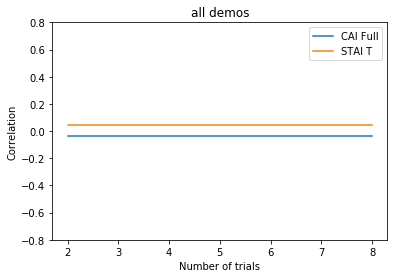

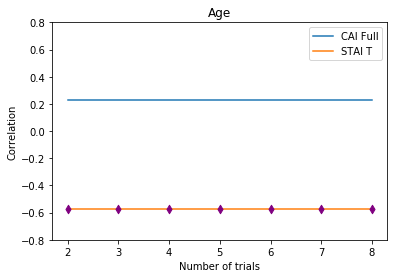

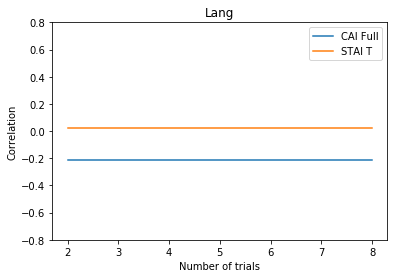

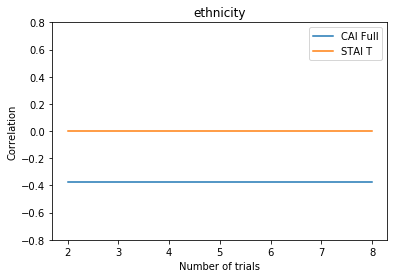

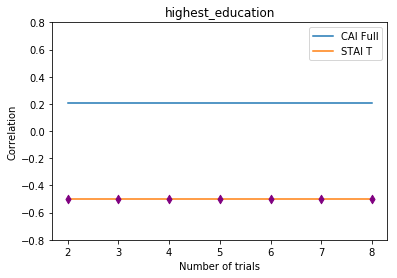

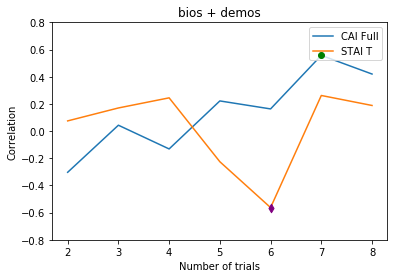

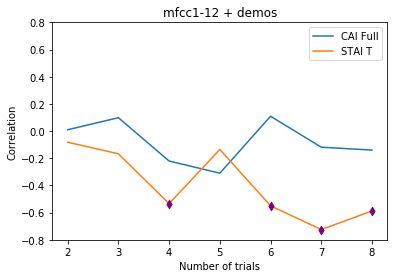

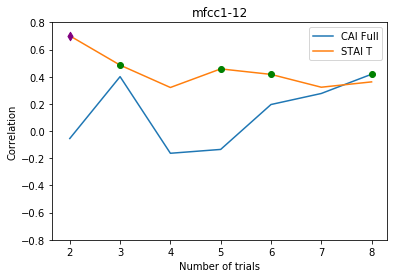

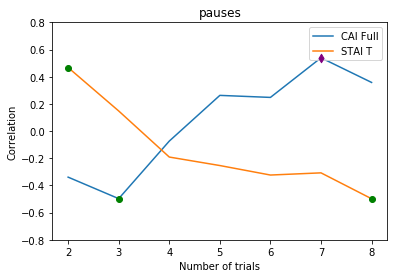

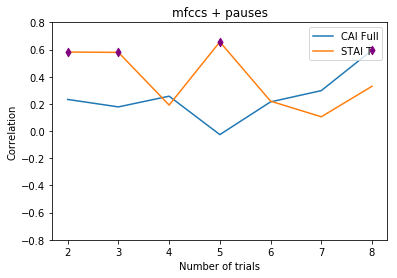

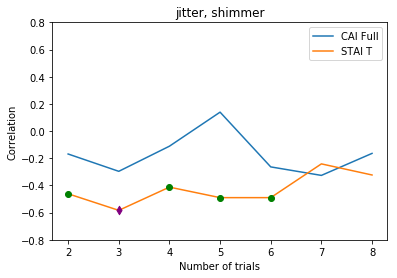

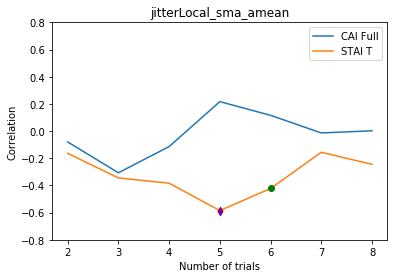

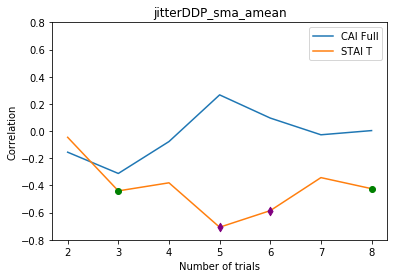

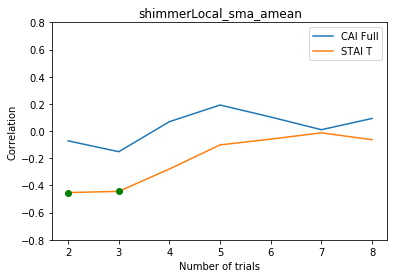

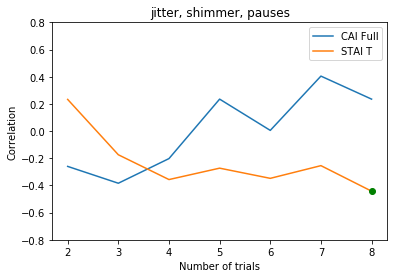

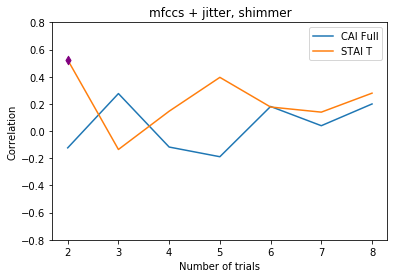

In [47]:
# Generate graphs showing how each variable changes over time with regards to each of the survey measures
correlations = []
pvalues = []

feature_set = ['all demos', 'Age', 'Lang', 'ethnicity', 'highest_education', 'bios + demos', 'mfcc1-12 + demos', 'mfcc1-12', 'pauses', 'mfccs + pauses', 'jitter, shimmer', 'jitterLocal_sma_amean', 'jitterDDP_sma_amean', 'shimmerLocal_sma_amean', 'jitter, shimmer, pauses', 'mfccs + jitter, shimmer', 'mfccs + jitter shimmer + pauses', 'all bio', 'HR_PPT, EDA_FREQ_PPT', 'bio + jitter, shimmer', 'bio + jitter, shimmer + pauses', 'bio + pauses', 'bio + mfcc']
demo_feature_set = ['mfcc1-12', 'pauses', 'mfccs + pauses', 'jitter, shimmer', 'jitterLocal_sma_amean', 'jitterDDP_sma_amean', 'shimmerLocal_sma_amean', 'jitter, shimmer, pauses', 'mfccs + jitter, shimmer', 'mfccs + jitter shimmer + pauses', 'all bio', 'HR_PPT, EDA_FREQ_PPT', 'bio + jitter, shimmer', 'bio + jitter, shimmer + pauses', 'bio + pauses', 'bio + mfcc']

for i in range(2, 9):
    e4_slopes_trunc, _ = get_slopes(e4_data, 1, i)
    audio_slopes_trunc, _ = get_slopes(audio_data, 1, i)
    #c, p, n, titles = combos_with_demo(e4_slopes_trunc, audio_slopes_trunc, 'ethnicity')
    c, p, n, titles = generate_combos(e4_slopes_trunc, audio_slopes_trunc)
    correlations.append(c)
    pvalues.append(p)

    
#fig.subplots_adjust(hspace=0.45, wspace=0.3)
for i in range(16):
    fig = plt.figure()
    #feature = [p_set[i] for p_set in pvalues]
    feature = [c_set[i] for c_set in correlations]
    pvals = [p_set[i] for p_set in pvalues]
    cai_f = np.asarray([vals[0] for vals in feature])
    stai_t = np.asarray([vals[1] for vals in feature])
    cai_f_pvals = np.asarray([vals[0] for vals in pvals])
    stai_t_pvals = np.asarray([vals[1] for vals in pvals])
    num_trials = np.arange(2, 9)
    
    #print(cai_f)
    #print(cai_f_pvals)
    if feature_set[i] == 'pauses':
        print(cai_f)
    
    sig1_x = []  # less significant
    sig1_y = []
    sig2_x = []  # most significant
    sig2_y = []
    for j in range(7):
        if cai_f_pvals[j] < 0.015:
            sig2_y.append(cai_f[j])
            sig2_x.append(j+2)
        elif cai_f_pvals[j] < 0.055:
            sig1_y.append(cai_f[j])
            sig1_x.append(j+2)
        if stai_t_pvals[j] < 0.015:
            sig2_y.append(stai_t[j])
            sig2_x.append(j+2)
        elif stai_t_pvals[j] < 0.055:
            sig1_y.append(stai_t[j])
            sig1_x.append(j+2)
    
    
    #ax = fig.add_subplot(8, 2, i+1)
    ax = plt.axes()
    #ax.set_ylim(0.0, 0.2)
    ax.set_ylim(-0.8, 0.8)
    plt.scatter(sig1_x, sig1_y, c='green', zorder=10)
    plt.scatter(sig2_x, sig2_y, c='purple', marker='d', zorder=9)
    ax.plot(num_trials, cai_f, label='CAI Full', zorder=3)
    ax.plot(num_trials, stai_t, label='STAI T', zorder=5)
    plt.ylabel('Correlation')
    plt.xlabel('Number of trials')
    plt.title(feature_set[i])
    ax.legend(loc="upper right")
    plt.savefig(DATA_PATH + 'slimmed/' + 'change-with-trials-new-' + feature_set[i])
    #plt.close()